<a href="https://colab.research.google.com/github/ishandahal/stats453-deep_learning_torch/blob/main/multi_layered_perceptron/sigmoid_output_MSE_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Multi-layered Perceptron with Sigmoid output and MSE loss

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch

In [2]:
import time
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

## Setting and Dataset

In [4]:
random_seed = 123
batch_size = 100
num_epochs = 100
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

## MNIST DATASET

train_dataset = datasets.MNIST(root='data',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data',
                              train=False,
                              transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size)

for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)



torch.Size([100, 1, 28, 28])
torch.Size([100])


In [10]:
def to_onehot(y, num_classes):
    y_onehot = torch.FloatTensor(y.size(0), num_classes)
    y_onehot.zero_()
    tmp = y.view(-1, 1).long().to(torch.device('cpu'))
    y_onehot.scatter_(1, tmp, 1).float()
    return y_onehot

### Model

In [29]:
class MlpSigmoidMSE(torch.nn.Module):

    def __init__(self, num_features, num_hidden, num_classes):
        super(MlpSigmoidMSE, self).__init__()

        self.num_classes = num_classes

        ### 1st hidden layer
        self.layer_1 = torch.nn.Linear(num_features, num_hidden)
        self.layer_1.weight.detach().normal_(0.0, 0.1)
        self.layer_1.bias.detach().zero_()

        ## output layer
        self.layer_2 = torch.nn.Linear(num_hidden, num_classes)
        self.layer_2.weight.detach().normal_(0.0, 0.1)
        self.layer_2.bias.detach().zero_()

    def forward(self, x):
        z_1 = self.layer_1(x)
        a_1 = F.sigmoid(z_1)
        logits = self.layer_2(a_1)
        probas = F.sigmoid(logits)
        return logits, probas

## Model Initialization

torch.manual_seed(random_seed)
model = MlpSigmoidMSE(num_features=28*28,
                      num_hidden=100,
                      num_classes=10)
model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

def compute_mse(net, dataloader):
    curr_mse, num_examples = torch.zeros(net.num_classes).float(), 0
    with torch.no_grad():
        for features, targets in dataloader:
            features = features.view(-1, 28*28).to(device)
            logits, probas = net(features)
            y_onehot = to_onehot(targets, net.num_classes)
            loss = torch.sum((y_onehot - probas)**2, dim=0)
            num_examples += targets.size(0)
            curr_mse += loss
        
        print(curr_mse.shape)
        curr_mse = torch.mean(curr_mse/num_examples)
        return curr_mse

start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):

        features = features.view(-1, 28*28).to(device)

        # forward prop and back prop
        logits, probas = model(features)

        y_onehot = to_onehot(targets, model.num_classes).to(device)

        cost = F.mse_loss(y_onehot, probas)
        optimizer.zero_grad()

        cost.backward()
        minibatch_cost.append(cost)

        optimizer.step()

        if not batch_idx % 50:
            print(f"Epoch: {epoch+1:03d}/{num_epochs:03d} | Batch {batch_idx:03d}/{len(train_loader)}"
                  f" | Cost: {cost:.4f}")
    
    cost = compute_mse(model, train_loader)
    epoch_cost.append(cost)
    print(f"Epoch: {epoch+1:03d}/{num_epochs} Train cost: {cost:.4f}")
    print(f"Time elapsed: {(time.time() - start_time)/60:.2f}min")

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 001/100 | Batch 000/600 | Cost: 0.2134
Epoch: 001/100 | Batch 050/600 | Cost: 0.1000
Epoch: 001/100 | Batch 100/600 | Cost: 0.0917
Epoch: 001/100 | Batch 150/600 | Cost: 0.0897
Epoch: 001/100 | Batch 200/600 | Cost: 0.0890
Epoch: 001/100 | Batch 250/600 | Cost: 0.0881
Epoch: 001/100 | Batch 300/600 | Cost: 0.0884
Epoch: 001/100 | Batch 350/600 | Cost: 0.0882
Epoch: 001/100 | Batch 400/600 | Cost: 0.0880
Epoch: 001/100 | Batch 450/600 | Cost: 0.0878
Epoch: 001/100 | Batch 500/600 | Cost: 0.0866
Epoch: 001/100 | Batch 550/600 | Cost: 0.0883
torch.Size([10])
Epoch: 001/100 Train cost: 0.0870
Time elapsed: 0.18min
Epoch: 002/100 | Batch 000/600 | Cost: 0.0872
Epoch: 002/100 | Batch 050/600 | Cost: 0.0860
Epoch: 002/100 | Batch 100/600 | Cost: 0.0879
Epoch: 002/100 | Batch 150/600 | Cost: 0.0845
Epoch: 002/100 | Batch 200/600 | Cost: 0.0855
Epoch: 002/100 | Batch 250/600 | Cost: 0.0861
Epoch: 002/100 | Batch 300/600 | Cost: 0.0848
Epoch: 002/100 | Batch 350/600 | Cost: 0.0836
Epoch: 

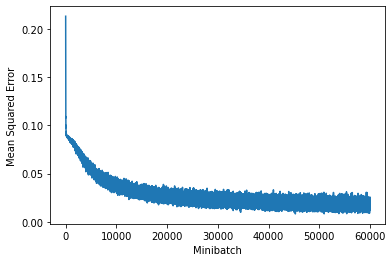

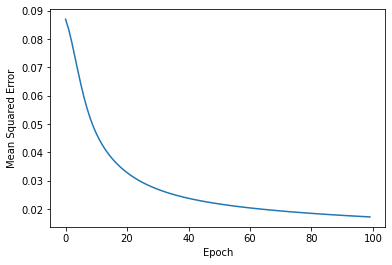

In [31]:
plt.plot(minibatch_cost)
plt.ylabel('Mean Squared Error')
plt.xlabel('Minibatch')
plt.show()

plt.plot(epoch_cost)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.show()

In [32]:
def compute_accuracy(net, data_loader):
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for features, labels in data_loader:
            features = features.view(-1, 28*28).to(device)
            a_1, a_2 = net(features)
            predicted_labels = torch.argmax(a_2, dim=1)
            num_examples += features.size(0)
            correct_pred += torch.sum(predicted_labels.float() == labels)
        return correct_pred.float()/num_examples * 100

print(f"Training accuracy: {compute_accuracy(model, train_loader):.2f}")
print(f"Testing accuracy: {compute_accuracy(model, test_loader):.2f}")

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Training accuracy: 90.66
Testing accuracy: 91.08
